In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import time
import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Following are visulization environment setup referred from TA: Boxi Xia

In [2]:
def setView(ctr,camera_pos=(1,1,1), lookat=(0, 0, 0), up=(0.5, 0.5, 1)):
    """
    set the view given a view control handel ctr
    """
    ctr.set_constant_z_far(100) # camera z far clip plane
    ctr.set_constant_z_near(0.01)# camera z near clip plane
    
def customVisualization(geomtry_list):
    """
    helper function to create a visualization given a list of o3d geometry
    """
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    for g in geomtry_list:
        vis.add_geometry(g)
    ctr = vis.get_view_control()
    setView(ctr)
    vis.run()
    vis.destroy_window() # close the window when finished
    
def createPlane(r=8, dr=0.1):
    """
    return a plane located at (0,0,0),and with plane normal = (0,0,1)
    r: radius of the plane
    dr:discretization radius of the grid
    """
    bounds = np.array([[-r, -r, 0],[r, r, 0]])/dr
    bounds = np.stack((np.floor(bounds[0]), np.ceil(bounds[1])))*dr
    nx, ny, nz = np.ceil((bounds[1]-bounds[0])/dr).astype(int)
#     print(nx,ny)
    xyz = np.reshape([[[[i, j, 0], [i+1, j, 0], [i, j+1, 0],
                       [i, j+1, 0], [i+1, j, 0], [i+1, j+1, 0]] for i in range(nx-1)] for j in range(ny-1)], (-1, 3))
    xyz = (xyz - ((nx-1)/2,(ny-1)/2,0))*dr
#     xyz, bounds, (nx, ny, nz) = create_grid(bounds, dr)
#     print(nx, ny, nz)
    triangles = np.arange(xyz.shape[0]).reshape((-1,3))
    plane = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(
        xyz), o3d.utility.Vector3iVector(triangles))
    # assign checkerboard color pattern
    c0 = (0.729, 0.78, 0.655) # first color
    c1 = (0.533, 0.62, 0.506) # second color
    colors = np.reshape([[np.tile(c0 if (i+j)%2 else c1,(6,1)) for i in range(nx-1)] for j in range(ny-1)],(-1,3))
    plane.vertex_colors = o3d.utility.Vector3dVector(colors)
    plane.compute_triangle_normals()
    return plane

# create a plane
plane = createPlane()
# create a coordinate frame
coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])


## Following are the functions to generate masses and springs of a six-arm  robot

In [3]:

def generateRandomArmLength(min_length = 0, max_length = 8, num_arm = 6):
    #generate a 6 elements arm length array
    np.random.seed()
    arm_length = [np.random.randint(min_length, max_length) for i in range(num_arm)]
    arm_length.insert(0, 0)
    return np.array(arm_length, dtype = np.int64)


def createRobotLocation(arm_length, edge, center_point = (0,0,0)):
    '''
    ROBOT_HEIGHT is the initial height we added to the robot, arm_length is the number of cubes per arm
    In this robot, we have one body with 8 cubes, 6 arms with 4 cubes each. You can set the arm_length to other number
    The center point of the robot is index14， mass_pos_list[14] = center_point
    '''
    mass_pos_list = []
    x0, y0, z0 = center_point
    #create the location of center body
    body = [[x0 + i * edge,y0 + j * edge,z0 + k * edge] for i in range(-1,2) for j in range(-1,2) for k in range(-1,2)]
    mass_pos_list.extend(body)
    #create the location of eight arms
    arm_vector = [[2*edge, 0, 0], [-2*edge, 0,0], [0, 2*edge, 0], [0,-2*edge,0], [0, 0, 2*edge], [0,0,-2*edge]]
    for vector in arm_vector:
        if vector[0] > 0:
            arm = [[2*edge + i*edge, 0.5 * j * np.sqrt(2*(edge**2)), z0+0.5 * k * np.sqrt(2*(edge**2))] \
                   for i in range(int(arm_length[1])) for j in [-1,0,1] for k in [-1,0,1] if (j!=k) and (j*k==0)]
        elif vector[0] < 0:
            arm = [[-2*edge - i*edge, 0.5 * j * np.sqrt(2*(edge**2)), z0+0.5 * k * np.sqrt(2*(edge**2))] \
                   for i in range(int(arm_length[2])) for j in [-1,0,1] for k in [-1,0,1] if (j!=k) and (j*k==0)]
        elif vector[1] > 0:
            arm = [[0.5 * i * np.sqrt(2*(edge**2)), 2*edge+j*edge, z0+0.5 * k * np.sqrt(2*(edge**2))] \
                   for j in range(int(arm_length[3])) for i in [-1,0,1] for k in [-1,0,1] if (i!=k) and (i*k==0)]
        elif vector[1] < 0:
            arm = [[0.5 * i * np.sqrt(2*(edge**2)), -2*edge-j*edge, z0+0.5 * k * np.sqrt(2*(edge**2))] \
                   for j in range(int(arm_length[4])) for i in [-1,0,1] for k in [-1,0,1] if (i!=k) and (i*k==0)]
        elif vector[2] > 0:
            arm = [[0.5 * i * np.sqrt(2*(edge**2)), 0.5 * j * np.sqrt(2*(edge**2)), z0+2*edge+k*edge,] \
                   for k in range(int(arm_length[5])) for i in [-1,0,1] for j in [-1,0,1] if (i!=j) and (i*j==0)]
        elif vector[2] < 0:
            arm = [[0.5 * i * np.sqrt(2*(edge**2)), 0.5 * j * np.sqrt(2*(edge**2)), z0-2*edge-k*edge,] \
                   for k in range(int(arm_length[6])) for i in [-1,0,1] for j in [-1,0,1] if (i!=j) and (i*j==0)]
        mass_pos_list.extend(arm)
    return np.array(mass_pos_list, dtype = np.float64)


def rotateRobotOnGround(mass_pos_list, max_robot_height):
    #rotate the robot in x,y,z axis
    rotation_x = np.radians(45)
    true_height = max_robot_height
    ground_height = np.sqrt(2) * true_height / 2
    rotation_y = np.arctan2(ground_height, true_height)
    rotation_z = np.radians(0)

    c_x, s_x = np.cos(rotation_x), np.sin(rotation_x)
    R_x = np.array(((1,0,0),(0,c_x,-s_x),(0,s_x,c_x)), dtype = np.float64)
    c_y, s_y = np.cos(rotation_y), np.sin(rotation_y)
    R_y = np.array(((c_y,0,s_y),(0,1,0),(-s_y,0,c_y)), dtype = np.float64)
    c_z, s_z = np.cos(rotation_z), np.sin(rotation_z)
    R_z = np.array(((c_z,-s_z,0),(s_z,c_z,0),(0,0,1)), dtype = np.float64)

    temp1 = (R_x @ mass_pos_list.T).T
    temp2 = (R_y @ temp1.T).T
    temp3 = (R_z @ temp2.T).T
    rotated_mass_pos_list = temp3
    
    #find the lowest max, set its position on ground while other masses will move too
    lowest_mass_z_pos = np.min(rotated_mass_pos_list[:,2]) 
    rotated_mass_pos_list[:,2] -= (lowest_mass_z_pos - 0.2)
    
    center_point = [0,0,0]
    cx, cy, cz = rotated_mass_pos_list[14]
    center_point = [cx,cy,cz]
    return rotated_mass_pos_list, center_point


def getMassDistance(m1_pos, m2_pos):
    return np.linalg.norm(np.array(m1_pos) - np.array(m2_pos), ord = 2)   


def getSpringList(mass_pos_list, long_diagonal, spring_k):
    spring_list = []
    mass_num = len(mass_pos_list)
    for i in range(mass_num):
        for j in range(i+1, mass_num):
            dis = getMassDistance(mass_pos_list[i], mass_pos_list[j])
            if dis <= long_diagonal +0.001:
                spring_list.append([spring_k, dis, i,j])
    return spring_list

In [4]:
#get all of the properties in numpy array of mass and spring

def getMassSpringProperties(arm_length, edge, long_diagonal, spring_k):
    mass_pos_list = np.asarray(createRobotLocation(arm_length, edge))
    max_robot_height = np.max(arm_length) #the max arm length decide how height the robot is
    mass_pos_list, center_point = np.asarray(rotateRobotOnGround(mass_pos_list, max_robot_height))
    spring_list = np.asarray(getSpringList(mass_pos_list, long_diagonal, spring_k))

    num_mass = len(mass_pos_list)
    #print(f"The number of mass is {num_mass}")
    mass_m = np.ones(num_mass,dtype=np.float64) * 0.1
    mass_pos = np.asarray(mass_pos_list,dtype=np.float64)
    mass_vel = np.zeros((num_mass,3),dtype=np.float64)
    mass_acc = np.zeros((num_mass,3),dtype=np.float64)

    num_spring =len(spring_list)
    #print(f"The number of spring is {num_spring}")
    spring_k = np.asarray(spring_list[:,0],dtype=np.float64)
    spring_rest = np.asarray(spring_list[:,1],dtype=np.float64) # rest length
    spring_ind = np.asarray(spring_list[:,2:],dtype=np.int64)
    return num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, center_point

In [5]:
#the robot has 6 arms, each arm has its own set of k, b, c. To make the representation easy, we split the spring in 7 groups
#, which are 1 body group and 6 arm groups

def splitSpring(spring_ind, num_mass, num_spring, arm_length):
    body_spring_ind = []
    arm0_spring_ind = []
    arm1_spring_ind = []
    arm2_spring_ind = []
    arm3_spring_ind = []
    arm4_spring_ind = []
    arm5_spring_ind = []
    num_mass_body = 27
    num_arm = 6
    
    arm_index_range = []
    right_index = num_mass_body
    for length in arm_length[1:]:
        left_index = right_index
        right_index = left_index + length * 4
        arm_index_range.append((left_index, right_index))
    arm_index_range = np.asarray(arm_index_range, dtype = np.int64)
    
    #assign each spring_ind's index into a 2d array
    for index, each in enumerate(spring_ind):
        mass1_index, mass2_index = each
        if mass1_index in range(arm_index_range[0][0], arm_index_range[0][1]) and mass2_index in range(arm_index_range[0][0], arm_index_range[0][1]):
            arm0_spring_ind.append(index)
        elif mass1_index in range(arm_index_range[1][0], arm_index_range[1][1]) and mass2_index in range(arm_index_range[1][0], arm_index_range[1][1]):
            arm1_spring_ind.append(index)
        elif mass1_index in range(arm_index_range[2][0], arm_index_range[2][1]) and mass2_index in range(arm_index_range[2][0], arm_index_range[3][1]):
            arm2_spring_ind.append(index)
        elif mass1_index in range(arm_index_range[3][0], arm_index_range[3][1]) and mass2_index in range(arm_index_range[3][0], arm_index_range[3][1]):
            arm3_spring_ind.append(index)
        elif mass1_index in range(arm_index_range[4][0], arm_index_range[4][1]) and mass2_index in range(arm_index_range[4][0], arm_index_range[4][1]):
            arm4_spring_ind.append(index)
        elif mass1_index in range(arm_index_range[5][0], arm_index_range[5][1]) and mass2_index in range(arm_index_range[5][0], arm_index_range[5][1]):
            arm5_spring_ind.append(index)
        else:
            body_spring_ind.append(index)
    return [body_spring_ind, arm0_spring_ind, arm1_spring_ind, arm2_spring_ind, arm3_spring_ind, arm4_spring_ind, arm5_spring_ind]

In [6]:
#get the velocity of robot

def getFitnessVelocity(center_mass_pos, T_MAX, center_point):
    center_x, center_y, _ = center_point
    cur_x, cur_y, _ = center_mass_pos
    #print(f"center point in getFitnessVelocity fun: {center_mass_pos}, {center_point}")
    diff_x, diff_y = center_x - cur_x, center_y - cur_y
    dis = np.linalg.norm([diff_x, diff_y], ord = 2)
    velocity = dis / T_MAX
    return velocity

In [7]:
#get the maximum diameter per cycle

def getRobotMaxSizePerCycle(velocity, omega, robot_length):
    cycle = 2 * np.pi / omega  # second per cycle
    velocity_per_cycle = cycle * velocity #meter per cycle
    max_size_per_cycle = velocity_per_cycle / robot_length #how many robot length the robot move per cycle
    return max_size_per_cycle

# Change Here! 
## The randomParameters function helps you to self-identify the properties range and make your own properties

In [8]:

def randomParameters(num_arm = 6):
    np.random.seed()
    parameters = np.zeros((7,5), dtype = np.object)
    
    omega_arm_range = [6,15]
    arm_length = generateRandomArmLength(min_length = 1, max_length = 8, num_arm = 6)
    #print(f"the arm_length is {arm_length}")
    k_body_range = [3000,5000]
    k_arm_range = [7000,20000]
    b_arm_range = [-0.4, 0.4]
    
    #in the order of arm_length, omega, k, b, c
    for i in range(num_arm+1):
        if i == 0:
            parameters[i,0] = arm_length[i]
            parameters[i,1] = 0
            parameters[i,2] = np.random.randint(k_body_range[0], k_body_range[1])
            parameters[i,3] = 0
            parameters[i,4] = 0
        else:
            parameters[i,0] = arm_length[i]  #len(arm_length) = 6 while num_arm+1 = 7
            parameters[i,1] = np.random.randint(omega_arm_range[0], omega_arm_range[1])
            parameters[i,2] = np.random.randint(k_arm_range[0], k_arm_range[1])
            parameters[i,3] = np.random.uniform(b_arm_range[0], b_arm_range[1])
            parameters[i,4] = np.random.uniform(-2 * np.pi / parameters[i,1], 2 * np.pi / parameters[i,1])
    return parameters    #in the order of arm_length, omega, k, b, c

In [9]:
# This function run the simulation in a visual GUI

def runSimulation(plane, lsd, parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, \
                  spring_rest, spring_ind, center_point, different_arm_spring_index, DT, T_MAX, OMEGA):
    GROUND_K = 100000
    DAMPING = 0.999
    DT = DT
    OMEGA = parameters[:,1]
    GRAVITY = 9.81
    MU_S = 1.0 #static friction coefficient of rubber on concrete
    MU_K = 0.8 #sliding friction coefficient of rubber on concrete
    T = 0
    T_MAX = T_MAX
    
    ended=False
    def signalEnd(vis):
        nonlocal ended
        ended =True
        
    vis = o3d.visualization.VisualizerWithKeyCallback()
    # ref:https://www.glfw.org/docs/3.3/group__keys.html
    # press key Q or ESC to close the window
    vis.register_key_callback(81, signalEnd)# key Q 
    vis.register_key_callback(256, signalEnd)# key escape
    vis.create_window()
    
    vis.add_geometry(lsd)
    vis.add_geometry(plane)   
    
    # view control
    ctr = vis.get_view_control()
    setView(ctr, camera_pos=(1,1,1), lookat=(0, 0, 0), up=(0,0, 1))
    
    loop_num = 0
    #change the spring_k:
    spring_current_k = np.copy(spring_k)
    for i in range(7):
        spring_current_k[different_arm_spring_index[i]] = parameters[i,2]
    
    while T < T_MAX:
        T += DT
        #set the force to zero every loop
        spring_force = np.zeros((num_spring),dtype=np.float64)
        mass_force = np.zeros((num_mass,3),dtype=np.float64)
        

        #change the spring_rest with t
        spring_current_rest = np.copy(spring_rest)

        for i in range(7):
            if i != 0:
                spring_current_rest[different_arm_spring_index[i]] *= 1 + parameters[i,3] * np.sin(OMEGA[i] * T + parameters[i,4])
                
        #get the spring_force
        spring_vec = mass_pos[spring_ind[:,1]] - mass_pos[spring_ind[:,0]]
        spring_vec_norm = np.linalg.norm(spring_vec,axis = 1)
        spring_unit_vec = spring_vec/ spring_vec_norm[:, np.newaxis]
        spring_force = ((spring_vec_norm - spring_current_rest) * spring_current_k)[:,np.newaxis] * spring_unit_vec
        np.add.at(mass_force, spring_ind[:,0], spring_force)
        np.add.at(mass_force, spring_ind[:,1], -spring_force)

        #get the gravity force
        mass_force[:,2] -= mass_m * GRAVITY

        #get the restoration_force
        mass_pos_below_zero = mass_pos[:,2] <= 0 #give a bool array when the z value of mass_pos is below zero

        #get coulomb friction
        normal_force_below_zero = mass_pos[:,2] < 0

        friction_available_index = np.asarray([i for i, val in enumerate(mass_pos_below_zero & normal_force_below_zero) if val])
        if np.any(friction_available_index):
            horizontal_force = np.sqrt(mass_force[friction_available_index,0]**2 + mass_force[friction_available_index,1]**2)
            normal_force = mass_force[friction_available_index,2]
            static_friction_index = np.array([i for i, val in zip(friction_available_index, horizontal_force < (-normal_force * MU_S)) \
                                                if val], dtype = np.int64)
            slide_friction_index = np.array([i for i, val in zip(friction_available_index, horizontal_force >= (-normal_force * MU_S)) \
                                               if val], dtype = np.int64)
            mass_force[static_friction_index,0] = 0.0
            mass_force[static_friction_index,1] = 0.0
            mass_vel[static_friction_index,0] = 0.0
            mass_vel[static_friction_index,1] = 0.0

            for index in slide_friction_index:
                if mass_force[index,0] < 0:
                    mass_force[index,0] += np.abs(mass_force[index,2]) * MU_K
                elif mass_force[index,0] >= 0:
                    mass_force[index,0] -= np.abs(mass_force[index,2]) * MU_K  
                elif mass_force[index,1] < 0:
                    mass_force[index,1] += np.abs(mass_force[index,2]) * MU_K    
                elif mass_force[index,1] >= 0:
                    mass_force[index,1] -= np.abs(mass_force[index,2]) * MU_K    
                    
        if np.any(mass_pos_below_zero):
            mass_force[mass_pos_below_zero, 2] -= GROUND_K * mass_pos[mass_pos_below_zero,2]

        #update the mass position
        mass_acc = mass_force/mass_m[:,np.newaxis]
        mass_vel += mass_acc * DT
        mass_vel *= DAMPING
        mass_pos += mass_vel * DT
        
        if loop_num % 100 == 0:
            lsd.points = o3d.utility.Vector3dVector(mass_pos)
            #o3d.visualization.draw_geometries([lsd])
            vis.update_geometry(lsd)
            vis.poll_events()
            vis.update_renderer()
            
        loop_num += 1
    return mass_pos, center_point

In [10]:
#This function run the simulation one time with one parameter set.

def runOneGeneration(parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, \
                     spring_ind, different_arm_spring_index, DT, T_MAX, OMEGA):
    
    OMEGA = parameters[:,1]
    DAMPING = 0.999
    DT = DT
    GRAVITY = 9.81
    MU_S = 1.0 #static friction coefficient of rubber on concrete
    MU_K = 0.8 #sliding friction coefficient of rubber on concrete
    T = 0
    T_MAX = T_MAX

    #change the spring_k:
    spring_current_k = np.copy(spring_k)
    for i in range(7):
        spring_current_k[different_arm_spring_index[i]] = parameters[i,2]
   
    #while loop
    loop_num = 0
    
    #used to calculate the kenimatic energy and potential energy
    total_energy_list = []
    stable_status = False
    center_point = [0,0,0]

    #total_energy = 0

    while T < T_MAX:
        T += DT
        #ke = 0
        #pe = 0

        #set the force to zero every loop
        spring_force = np.zeros((num_spring),dtype=np.float64)
        mass_force = np.zeros((num_mass,3),dtype=np.float64)
        
        #change the spring_rest with t
        spring_current_rest = np.copy(spring_rest)

        for i in range(7):
            if i != 0:
                spring_current_rest[different_arm_spring_index[i]] *= 1 + parameters[i,3] * np.sin(OMEGA[i] * T + parameters[i,4])

        #get the spring_force
        spring_vec = mass_pos[spring_ind[:,1]] - mass_pos[spring_ind[:,0]]
        spring_vec_norm = np.linalg.norm(spring_vec,axis = 1)
        spring_unit_vec = spring_vec/ spring_vec_norm[:, np.newaxis]
        spring_force = ((spring_vec_norm - spring_current_rest) * spring_current_k)[:,np.newaxis] * spring_unit_vec
        np.add.at(mass_force, spring_ind[:,0], spring_force)
        np.add.at(mass_force, spring_ind[:,1], -spring_force)
        #mass_force[spring_ind[:,0]] += spring_force[:,np.newaxis] * spring_unit_vec
        #mass_force[spring_ind[:,1]] -= spring_force[:,np.newaxis] * spring_unit_vec
        #pe += np.sum(0.5 * spring_current_k * np.power(spring_vec_norm - spring_current_rest, 2))

        #get the gravity force
        mass_force[:,2] -= mass_m * GRAVITY
        #pe += np.sum(GRAVITY * mass_m * mass_pos[:,2])

        #get the restoration_force
        mass_pos_below_zero = mass_pos[:,2] <= 0 #give a bool array when the z value of mass_pos is below zero

        #get coulomb friction
        normal_force_below_zero = mass_pos[:,2] < 0
        
        friction_available_index = np.asarray([i for i, val in enumerate(mass_pos_below_zero & normal_force_below_zero) if val])
        if np.any(friction_available_index):
            horizontal_force = np.sqrt(mass_force[friction_available_index,0]**2 + mass_force[friction_available_index,1]**2)
            normal_force = mass_force[friction_available_index,2]
            static_friction_index = np.array([i for i, val in zip(friction_available_index, horizontal_force < (-normal_force * MU_S)) \
                                                if val], dtype = np.int64)
            slide_friction_index = np.array([i for i, val in zip(friction_available_index, horizontal_force >= (-normal_force * MU_S)) \
                                               if val], dtype = np.int64)
            mass_force[static_friction_index,0] = 0.0
            mass_force[static_friction_index,1] = 0.0
            mass_vel[static_friction_index,0] = 0.0
            mass_vel[static_friction_index,1] = 0.0

            for index in slide_friction_index:
                if mass_force[index,0] < 0:
                    mass_force[index,0] += np.abs(mass_force[index,2]) * MU_K
                elif mass_force[index,0] >= 0:
                    mass_force[index,0] -= np.abs(mass_force[index,2]) * MU_K  
                elif mass_force[index,1] < 0:
                    mass_force[index,1] += np.abs(mass_force[index,2]) * MU_K    
                elif mass_force[index,1] >= 0:
                    mass_force[index,1] -= np.abs(mass_force[index,2]) * MU_K    
                    
        if np.any(mass_pos_below_zero):
            mass_force[mass_pos_below_zero, 2] -= GROUND_K * mass_pos[mass_pos_below_zero,2]
            #pe += np.sum(0.5 * GROUND_K * np.power(mass_pos[mass_pos_below_zero,2],2))

        #update the mass position
        mass_acc = mass_force/mass_m[:,np.newaxis]
        mass_vel += mass_acc * DT
        #ke += np.sum(0.5 * mass_m * np.power(np.linalg.norm(mass_vel, axis = 1), 2))
        mass_vel *= DAMPING
        mass_pos += mass_vel * DT
        
        #let the robot get stable then calculate the velocity, so here get the center_point when robot is stable
        if stable_status == False and T > 1:
            stable_status = True
            cx, cy, cz = mass_pos[14]
            center_point = [cx,cy,cz]
            
        #total_energy_list.append(pe+ke)
        loop_num += 1

    return mass_pos, center_point, total_energy_list

In [11]:
#get the initial parent_list and generate children_list from parent_list
def getInitialParent(parent_size):
    parent_list = np.asarray([randomParameters(num_arm = 6) for i in range(parent_size)])
    return parent_list
def getChildren(parent_list, mutation_rate = 0.02, crossover_rate = 0.1):
    num_parent = len(parent_list)
    num_mutation = int(np.ceil(mutation_rate * num_parent * 7 * 5)) #parameters shape is (7,3)
    num_crossover = int(np.ceil(crossover_rate * num_parent * 7))
    if num_crossover % 2 != 0:
        num_crossover += 1
    #print(f"The num of crossover is {num_crossover}")
    
    #mutation
    #print(f"The parent_list is {parent_list}")
    flatten_parent_list = parent_list.flatten()
    #print(f"The flatten_parent_list is {flatten_parent_list}")
    random_mutation_index = (np.random.choice(np.arange(num_parent * 7 * 5), size = num_mutation, replace = False))
    #print(f"The mutation_index is {random_mutation_index}")
    for index in random_mutation_index:
        if index % 5 == 0:
            if index % 35 == 0:
                continue
            random_num = np.random.randint(-2,3)
            flatten_parent_list[index] += random_num
            if flatten_parent_list[index] < 0:
                flatten_parent_list[index] = 0
        elif index % 5 == 1:
            if index % 35 == 1:
                continue
            random_num = np.random.randint(-2,3)
            flatten_parent_list[index] += random_num
            if flatten_parent_list[index] < 3:
                flatten_parent_list[index] = 3
        elif index % 5 == 2:
            random_num = np.random.randint(-1000,1000)
            flatten_parent_list[index] += random_num
            if flatten_parent_list[index] < 5000:
                flatten_parent_list[index] = 5000
        elif index % 35 == 3 or index % 35 == 4:
            continue
        else:
            random_scale = np.random.uniform(0.8,1.2)
            flatten_parent_list[index] *= random_scale
    mutated_children_list = np.reshape(flatten_parent_list, (num_parent,7,5))
    #print(f"The mutated_children_list is {mutated_children_list}")
    
    #crossover
    vstack_children_list = np.vstack(mutated_children_list)
    #print(f"The vstack_children_list is {vstack_children_list}")
    random_crossover_index = (np.random.choice(np.arange(num_parent * 7), size = num_crossover))
    #print(f"The crossover_index is {random_crossover_index}")
    for i in np.arange(0,len(random_crossover_index),2):
        #print(f"i is {i}")
        if random_crossover_index[i] % 7 == 0 or random_crossover_index[i+1] %7 == 0:
            continue
            #print(f"Can't crossover between body and arms")
        else:
            crossover_index = np.random.choice(np.arange(5), size = np.random.randint(0,6), replace = False) #random choose parameter to switch
            for index in crossover_index:
                temp = vstack_children_list[random_crossover_index[i]][index]
                vstack_children_list[random_crossover_index[i]][index] = vstack_children_list[random_crossover_index[i+1]][index]
                vstack_children_list[random_crossover_index[i+1]][index] = temp
    crossovered_children_list = np.reshape(vstack_children_list, (num_parent,7,5))
    #print(f"The crossovered_children_list is {crossovered_children_list}")
    return crossovered_children_list

In [12]:

def selection(velocity_list, parent_children_list, parent_size):
    #print(f"The velocity_list is {velocity_list}")
    #print(f"The parent_children_list is {parent_children_list}")
     #get the new velocity_list and parent_list relatively
    add_index_velocity_list = [[i, velocity_list[i]] for i in range(len(velocity_list))]
    sort_velocity_list = sorted(add_index_velocity_list, key = lambda x: x[1], reverse = True)
    sort_velocity_index_list = np.array(sort_velocity_list)[:,0].astype(np.int64)  #get the velocity index in descending velocity

    array_velocity_list = np.array(velocity_list)
    sort_array_velocity_list = array_velocity_list[sort_velocity_index_list]  #get the sorted velocity descending
    sort_parent_children_list = parent_children_list[sort_velocity_index_list]  #get the sorted parent_children list in descending velocity
    
    total_fitness = np.sum(sort_array_velocity_list)
    distance_between_pointers = total_fitness / parent_size
    start_pointer = np.random.uniform(0, distance_between_pointers)
    pointers = [start_pointer + i * distance_between_pointers for i in range(parent_size)]
    
    keep = [] #get the index
    for p in pointers:
        i = 0
        while np.sum(sort_array_velocity_list[:i+1]) < p:
            i += 1
        keep.append(i)
    
    velocity_list = sort_array_velocity_list[keep].tolist()
    print(f"The new velocity_list is {velocity_list}")
    parent_list = sort_parent_children_list[keep]
    #print(f"The new parent_list is {parent_list}")
    
    return velocity_list, parent_list

# Evolve Here!
## Get the parameters of parent_list, velocity per generation
* In our evolution, we apply breakpoint strategy. In each evolution, parameters and best_velocity will be saved, so you can use the saved parameters and best_velocity_list to continue evolving. 
* You don't need to start again, all you need is the parameters and best_velocity_list
* Here, we use pickle to save and load data

In [13]:
def evolutionary(generation = 10, parent_size = 20, previous_parent_list = None, previous_best_velocity_list = None):
    
    #important initial properties
    WEIGHT = 0.1
    SPRING_K = 10000
    GROUND_K = 100000
    DAMPING = 0.999
    EDGE = 0.1 
    SHORT_DIAGONAL = np.sqrt(2)/10
    LONG_DIAGONAL = np.sqrt(3)/10
    DT = 0.0001 #changable
    GRAVITY = 9.81
    MU_S = 1.0 #static friction coefficient of rubber on concrete
    MU_K = 0.8 #sliding friction coefficient of rubber on concrete
    T = 0
    T_MAX = 6.5 #changable
    
    
    #start from beginning
    if np.any(previous_parent_list) == None or np.any(previous_best_velocity_list) == None:
        velocity_list = []  #[velocity]
        best_velocity_list = []  #only install the first parent's velocity
        parent_list = getInitialParent(parent_size) #This is initial parent list
    else:
        velocity_list = []
        best_velocity_list = previous_best_velocity_list
        parent_list = previous_parent_list

    for i in range(generation):
        #showing the progress 
        #print(f"Generation: {i}")

        best_velocity = 0 #for each generation, record the best velocity

        #get the children and stack parent and children together for comparation
        children_list = getChildren(parent_list, mutation_rate = 0.05, crossover_rate = 0.4) #change the mutation_rate and crossover_rate here
        parent_children_list = np.vstack([parent_list, children_list])

        #If it is the first generation,go over the all parent_list and children_list to get the velocties
        if i == 0: 
            for i in range(len(parent_children_list)):
                print(f"Parent_Children_#{i}")
                parameters = parent_children_list[i]
                num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, center_point\
                    = getMassSpringProperties(arm_length = parameters[:,0], edge = EDGE, long_diagonal = LONG_DIAGONAL, spring_k = SPRING_K)
                different_arm_spring_index = splitSpring(spring_ind, num_mass, num_spring, arm_length = parameters[:,0])
                #print(f"The arm-length is {parameters[:,0]}")
                #print(f"The parameters are {parameters}")

                mass_pos, center_point, total_energy_list = \
                    runOneGeneration(parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, different_arm_spring_index, DT, T_MAX, OMEGA)     
                velocity = getFitnessVelocity(mass_pos[14], T_MAX, center_point)
                print(f"the velocity at parent_children {i} is !!!{velocity}!!!")
            
                '''
                #visulize the initial robot shape, close the window to continue
                lsd = o3d.geometry.LineSet()
                lsd.points = o3d.utility.Vector3dVector(mass_pos)
                lsd.lines = o3d.utility.Vector2iVector(spring_ind)
                plane = createPlane()
                #o3d.visualization.draw_geometries([lsd])
                customVisualization([lsd, plane])
                '''

                velocity_list.append(velocity)
                '''
                if velocity > 2:
                    print('WARNING！！！！！！')
                    print(parameters)
                if velocity > best_velocity:
                    best_velocity = velocity
                    print(f"Up to now, the best_velocity in the generation is {best_velocity}")
                '''

        #Once we get the first generation, we only need to calculate the velocity of children_list because we already know the velocties of parent_list
        else:
            for i in range(len(children_list)):
                #print(f"Parent_Children_#{i}")
                parameters = children_list[i]
                num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, center_point\
                    = getMassSpringProperties(arm_length = parameters[:,0], edge = EDGE, long_diagonal = LONG_DIAGONAL, spring_k = SPRING_K)
                different_arm_spring_index = splitSpring(spring_ind, num_mass, num_spring, arm_length = parameters[:,0])
                print(f"The parameters are {parameters}")
                
                mass_pos, center_point, total_energy_list = \
                    runOneGeneration(parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, different_arm_spring_index, DT, T_MAX, OMEGA)     
                velocity = getFitnessVelocity(mass_pos[14], T_MAX, center_point)

                print(f"the velocity at children {i} is {velocity}")
                
                '''
                #visulize the initial robot shape, close the window to continue
                lsd = o3d.geometry.LineSet()
                lsd.points = o3d.utility.Vector3dVector(mass_pos)
                lsd.lines = o3d.utility.Vector2iVector(spring_ind)
                plane = createPlane()
                #o3d.visualization.draw_geometries([lsd])
                customVisualization([lsd, plane])
                '''
                
                velocity_list.append(velocity)
                '''
                if velocity > 2:
                    print('WARNING！！！！！！')
                    print(parameters)
                if velocity > best_velocity:
                    best_velocity = velocity
                    print(f"Up to now, the best_velocity in the generation is {best_velocity}")
                '''

        
        velocity_list, parent_list = selection(velocity_list, parent_children_list, parent_size)
        best_velocity_list.append(velocity_list[0])
        
        #save the data in case the computer crash
        if generation % 1 == 0:
            with open('evolve_progress_save_parent_velocity_2.pkl', 'wb') as pickle_file:
                pickle.dump(parent_list, pickle_file)
                pickle.dump(best_velocity_list, pickle_file)

    return parent_list, best_velocity_list

### Run evolution code here
* Run the first cell below if you have changed above, or you don't have previous parameters record to continue
* Run the second cell below if you save your parameters record after evolution and wanna start from the previous parameters

In [195]:
#!!!!!!!!!!!Don't run this unless you wanna start a new evolution
parent_list, best_velocity_list = evolutionary()

In [51]:
#!!!!!!!!!!!!!Run this only you start from previous parent_list, best_velocity_list(used for fitness figure)
#The best_velocity_list is the velocity fitness list, which saves the best velocity in each evolution
#load the data from the pickle file
with open('evolve_progress_save_parent_velocity_2.pkl', 'rb') as pickle_file:
    parent_list = pickle.load(pickle_file)
    best_velocity_list = pickle.load(pickle_file)
print(parent_list, best_velocity_list)
parent_list, best_velocity_list = evolutionary(previous_parent_list = parent_list, previous_best_velocity_list = best_velocity_list)

[[[0 0 3983 0 0]
  [6 10 13667 0.46950848270713347 0.2396268502136798]
  [0 14 13667 -0.10552442445546945 0.2396268502136798]
  ...
  [7 5 13000 -0.0812218042676327 -0.5919038645682511]
  [5 11 20523 0.37471625939052206 0.45745940174173993]
  [6 5 20918 -0.1094668999655743 0.45745940174173993]]

 [[0 0 3983 0 0]
  [6 10 13667 0.46950848270713347 0.2396268502136798]
  [0 14 13667 -0.10552442445546945 0.2396268502136798]
  ...
  [7 5 13000 -0.0812218042676327 -0.5919038645682511]
  [5 11 20523 0.37471625939052206 0.45745940174173993]
  [6 5 20918 -0.1094668999655743 0.45745940174173993]]

 [[0 0 3983 0 0]
  [6 10 13667 0.3738096345163029 0.23429446998415246]
  [0 3 11515 -0.1094668999655743 0.2396268502136798]
  ...
  [7 5 13493 -0.0812218042676327 -0.5919038645682511]
  [5 11 20918 0.37471625939052206 0.45745940174173993]
  [3 3 14959 -0.0812218042676327 0.2396268502136798]]

 ...

 [[0 0 3983 0 0]
  [6 10 13667 0.3738096345163029 0.20591315611202038]
  [0 14 11515 -0.1094668999655743 0

KeyboardInterrupt: 

Text(0.5, 1.0, 'The fitness plot: 25 population')

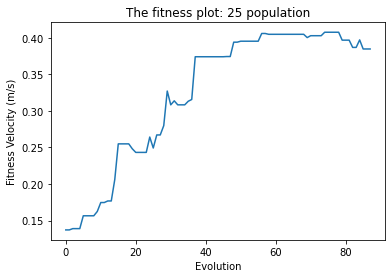

In [194]:
#Get the fitness figure
with open('evolve_progress_save_parent_velocity_1.pkl', 'rb') as pickle_file:
    parent_list = pickle.load(pickle_file)
    best_velocity_list = pickle.load(pickle_file)
plt.plot(range(len(best_velocity_list)), best_velocity_list)
plt.xlabel('Evolution')
plt.ylabel('Fitness Velocity (m/s)')
plt.title('The fitness plot: 25 population')

# Single Simulation
* The cell below will let you run single simulation with parameters

In [16]:
#important initial properties
WEIGHT = 0.1
SPRING_K = 10000
GROUND_K = 100000
DAMPING = 0.999
EDGE = 0.1 
OMEGA = 9
SHORT_DIAGONAL = np.sqrt(2)/10
LONG_DIAGONAL = np.sqrt(3)/10
DT = 0.0001 #changable
GRAVITY = 9.81
MU_S = 1.0 #static friction coefficient of rubber on concrete  #(Change Here)
MU_K = 0.8 #sliding friction coefficient of rubber on concrete   #(Change Here)
T = 0
T_MAX = 2 #changable

#get the parameters you want, change the file you want, get parameters from parent_list 
with open('evolve_progress_save_parent_velocity_2.pkl', 'rb') as pickle_file:
    parent_list = pickle.load(pickle_file)
    best_velocity_list = pickle.load(pickle_file)
print(best_velocity_list)
print("Length of parent_list is {}".format(len(parent_list)))
parameters = parent_list[0]

#This is the best one
parameters = np.array([[0, 0, 3983, 0, 0],
 [6, 11, 20918, 0.5254811968928025, 0.45745940174173993],
 [3, 16, 15043, -0.06650248473291916, 0.2396268502136798],
 [7, 3, 15813, -0.0812218042676327, 0.2396268502136798],
 [7, 5,13000, -0.08735069292410687, -0.5919038645682511],
 [6, 6, 20918, -0.1094668999655743, 0.22141698821848954],
 [6, 15, 13435, -0.1094668999655743, -0.2283695514602201]])


#initialize the mass properties and spring properties
num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, center_point\
                    = getMassSpringProperties(arm_length = parameters[:,0], edge = EDGE, long_diagonal = LONG_DIAGONAL, spring_k = SPRING_K)
different_arm_spring_index = splitSpring(spring_ind, num_mass, num_spring, arm_length = parameters[:,0])

#visulization setup
lsd1 = o3d.geometry.LineSet()
lsd1.points = o3d.utility.Vector3dVector(mass_pos)
lsd1.lines = o3d.utility.Vector2iVector(spring_ind)

#visulize
mass_pos, center_point = runSimulation(plane,lsd1, parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, center_point, different_arm_spring_index, DT, T_MAX, OMEGA)

#calculate the velocity
velocity = getFitnessVelocity(mass_pos[14], T_MAX, center_point)
print(f"The best_velocity is: {velocity}")
robot_max_size_per_cycle = getRobotMaxSizePerCycle(velocity, 9.3, 1.4)
print(f"The robot maximum size per cycle is: {robot_max_size_per_cycle}")

[0.0955513553123095, 0.12476798285582044, 0.12476798285582044, 0.15329739328687259, 0.1750508075993652, 0.19516112196155125, 0.19826953547416779, 0.24050691278464342, 0.24050691278464342, 0.26552215462347273, 0.26552215462347273, 0.26552215462347273, 0.29198246587764554, 0.351089569034945, 0.351089569034945, 0.35159182613356715, 0.3535041859402567, 0.3535041859402567, 0.3535041859402567, 0.36305519604709685, 0.36305519604709685, 0.36305519604709685, 0.36305519604709685, 0.37331372452964406, 0.37331372452964406, 0.37331372452964406, 0.37331372452964406, 0.37331372452964406, 0.37331372452964406, 0.40739174371675, 0.40739174371675, 0.42226262197956205, 0.46698142717489277, 0.46698142717489277, 0.46698142717489277, 0.46698142717489277, 0.46698142717489277, 0.4843115316184228, 0.4843115316184228, 0.4843115316184228, 0.4843115316184228, 0.4843115316184228, 0.4843115316184228, 0.4926124164302388, 0.4926124164302388, 0.4843115316184228, 0.4843115316184228, 0.4843115316184228, 0.473282027484938

# Robot Zoo Simulation Space
1. Get the evolved parent_list, which have multiple parameters
2. Use chosed parameters to run one evolution, record the mass position in 60 Hz/s. For example, if the evolution time is 10s, the total record has 600 mass positions
3. Use the record of mass position of each robot to run the simulation in Open3d

In [17]:
#This function run the simulation one time with one parameter set.

def runSimulationOneGeneration(parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, \
                     spring_ind, different_arm_spring_index, DT, T_MAX, OMEGA):
    
    DAMPING = 0.999
    DT = DT
    GRAVITY = 9.81
    MU_S = 1.0 #static friction coefficient of rubber on concrete
    MU_K = 0.8 #sliding friction coefficient of rubber on concrete
    T = 0
    T_MAX = T_MAX

    #change the spring_k:
    spring_current_k = np.copy(spring_k)
    for i in range(7):
        spring_current_k[different_arm_spring_index[i]] = parameters[i,2]

    loop_num = 0
    
    #used to calculate the kenimatic energy and potential energy
    #total_energy_list = []
    stable_status = False
    center_point = [0,0,0]
    
    #used in simulation one generation
    simulation_mass_pos_list = []

    while T < T_MAX:
        T += DT
        #ke = 0
        #pe = 0

        #set the force to zero every loop
        spring_force = np.zeros((num_spring),dtype=np.float64)
        mass_force = np.zeros((num_mass,3),dtype=np.float64)
        
        #change the spring_rest with t
        spring_current_rest = np.copy(spring_rest)

        for i in range(7):
            if i != 0:
                spring_current_rest[different_arm_spring_index[i]] *= 1 + parameters[i,3] * np.sin(OMEGA[i] * T + parameters[i,4])

        #get the spring_force
        spring_vec = mass_pos[spring_ind[:,1]] - mass_pos[spring_ind[:,0]]
        spring_vec_norm = np.linalg.norm(spring_vec,axis = 1)
        spring_unit_vec = spring_vec/ spring_vec_norm[:, np.newaxis]
        spring_force = ((spring_vec_norm - spring_current_rest) * spring_current_k)[:,np.newaxis] * spring_unit_vec
        np.add.at(mass_force, spring_ind[:,0], spring_force)
        np.add.at(mass_force, spring_ind[:,1], -spring_force)
        #mass_force[spring_ind[:,0]] += spring_force[:,np.newaxis] * spring_unit_vec
        #mass_force[spring_ind[:,1]] -= spring_force[:,np.newaxis] * spring_unit_vec
        #pe += np.sum(0.5 * spring_current_k * np.power(spring_vec_norm - spring_current_rest, 2))

        #get the gravity force
        mass_force[:,2] -= mass_m * GRAVITY
        #pe += np.sum(GRAVITY * mass_m * mass_pos[:,2])

        #get the restoration_force
        mass_pos_below_zero = mass_pos[:,2] <= 0 #give a bool array when the z value of mass_pos is below zero

        #get coulomb friction
        normal_force_below_zero = mass_pos[:,2] < 0
        
        friction_available_index = np.asarray([i for i, val in enumerate(mass_pos_below_zero & normal_force_below_zero) if val])
        if np.any(friction_available_index):
            horizontal_force = np.sqrt(mass_force[friction_available_index,0]**2 + mass_force[friction_available_index,1]**2)
            normal_force = mass_force[friction_available_index,2]
            static_friction_index = np.array([i for i, val in zip(friction_available_index, horizontal_force < (-normal_force * MU_S)) \
                                                if val], dtype = np.int64)
            slide_friction_index = np.array([i for i, val in zip(friction_available_index, horizontal_force >= (-normal_force * MU_S)) \
                                               if val], dtype = np.int64)
            mass_force[static_friction_index,0] = 0.0
            mass_force[static_friction_index,1] = 0.0
            mass_vel[static_friction_index,0] = 0.0
            mass_vel[static_friction_index,1] = 0.0

            for index in slide_friction_index:
                if mass_force[index,0] < 0:
                    mass_force[index,0] += np.abs(mass_force[index,2]) * MU_K
                elif mass_force[index,0] >= 0:
                    mass_force[index,0] -= np.abs(mass_force[index,2]) * MU_K  
                elif mass_force[index,1] < 0:
                    mass_force[index,1] += np.abs(mass_force[index,2]) * MU_K    
                elif mass_force[index,1] >= 0:
                    mass_force[index,1] -= np.abs(mass_force[index,2]) * MU_K    
                    
        if np.any(mass_pos_below_zero):
            mass_force[mass_pos_below_zero, 2] -= GROUND_K * mass_pos[mass_pos_below_zero,2]
            #pe += np.sum(0.5 * GROUND_K * np.power(mass_pos[mass_pos_below_zero,2],2))

        #update the mass position
        mass_acc = mass_force/mass_m[:,np.newaxis]
        mass_vel += mass_acc * DT
        #ke += np.sum(0.5 * mass_m * np.power(np.linalg.norm(mass_vel, axis = 1), 2))
        mass_vel *= DAMPING
        mass_pos += mass_vel * DT
        
        #let the robot get stable then calculate the velocity, so here get the center_point when robot is stable
        if stable_status == False and T > 1:
            stable_status = True
            cx, cy, cz = mass_pos[14]
            center_point = [cx,cy,cz]
            
        #total_energy_list.append(pe+ke)
        
        #10000runs per second, capture the mass_pos in 60 frames per second
        if loop_num % int(1/DT/60) == 0:
            simulation_mass_pos = mass_pos.copy()
            simulation_mass_pos_list.append(simulation_mass_pos)

        loop_num += 1
            

    return mass_pos, center_point, simulation_mass_pos_list

### Function DIY instruction
1. In getSimulationParentList, we get the parameters we need and stack them together for further operation
2. In getSimulationMassPos, we get the record of mass position and the spring index(used to connect mass) of a robot
3. In runZooSimulation, we simulate every robot on the same plane

In [18]:
def getSimulationParentList():
    pick_up_index_1 = [0,10,20] #changable
    with open('evolve_progress_save_parent_velocity_1.pkl', 'rb') as pickle_file:
        parent_list_1 = pickle.load(pickle_file)
        best_velocity_list_1 = pickle.load(pickle_file)
    print(best_velocity_list_1)
    print("The length of best_velocity_list1 is {}".format(len(best_velocity_list_1)))
    
    
    pick_up_index_2 = [0,15,30] #changable
    with open('evolve_progress_save_parent_velocity_2.pkl', 'rb') as pickle_file:
        parent_list_2 = pickle.load(pickle_file)
        best_velocity_list_2 = pickle.load(pickle_file)
    print(best_velocity_list_2)
    print("The length of best_velocity_list1 is {}".format(len(best_velocity_list_2)))
    
    pick_up_index_short = [0,10,20] #changable
    with open('evolve_progress_save_parent_velocity_short.pkl', 'rb') as pickle_file:
        parent_list_short = pickle.load(pickle_file)
        best_velocity_list_short = pickle.load(pickle_file)
    print(best_velocity_list_short)
    print("The length of best_velocity_list1 is {}".format(len(best_velocity_list_short)))
    
    pick_up_parent_list_1 = parent_list_1[pick_up_index_1]
    pick_up_parent_list_2 = parent_list_2[pick_up_index_2]
    pick_up_parent_list_short = parent_list_short[pick_up_index_short]
    simulation_parent_list = np.vstack((pick_up_parent_list_1,pick_up_parent_list_2,pick_up_parent_list_short))
    return simulation_parent_list


def getSimulationMassPos(paremeters):
    SPRING_K = 10000
    GROUND_K = 100000
    EDGE = 0.1 
    SHORT_DIAGONAL = np.sqrt(2)/10
    LONG_DIAGONAL = np.sqrt(3)/10
    DT = 0.0001 #changable
    OMEGA = parameters[:,1]
    T_MAX = 12 #changable
    num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, spring_ind, center_point\
                    = getMassSpringProperties(arm_length = parameters[:,0], edge = EDGE, long_diagonal = LONG_DIAGONAL, spring_k = SPRING_K)
    different_arm_spring_index = splitSpring(spring_ind, num_mass, num_spring, arm_length = parameters[:,0])
    mass_pos, center_point, simulation_mass_pos_list = runSimulationOneGeneration(parameters, num_mass, mass_m, mass_pos, mass_vel, mass_acc, num_spring, spring_k, spring_rest, \
                     spring_ind, different_arm_spring_index, DT, T_MAX, OMEGA)
    
    #get the velocity
    velocity = getFitnessVelocity(mass_pos[14], T_MAX, center_point)
    print(f"The velocity is: {velocity}")
    
    return simulation_mass_pos_list, spring_ind

def runZooSimulation(total_simulation_mass_pos_list, total_spring_ind):
    num_robot = len(total_simulation_mass_pos_list)
    vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()
    plane = createPlane()
    vis.add_geometry(plane)
    
    color_choose = [[1,0.4,0],[1,0.4,0],[1,0.4,0],[0,0.46,0.77],[0,0.46,0.77],[0,0.46,0.77],[1,0.87,0],[1,0.87,0],[1,0.87,0]]
        
    #based on the number of robot, change the lsd here
    lsd0 = o3d.geometry.LineSet()
    lsd0.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[0][0]) # (n by 3) arry of points xyzs
    lsd0.lines = o3d.utility.Vector2iVector(total_spring_ind[0])
    colors0 = [color_choose[7] for i in range(len(total_spring_ind[0]))]
    lsd0.colors = o3d.utility.Vector3dVector(colors0)
    vis.add_geometry(lsd0)
    
    lsd1 = o3d.geometry.LineSet()
    lsd1.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[1][0]) # (n by 3) arry of points xyzs
    lsd1.lines = o3d.utility.Vector2iVector(total_spring_ind[1])
    colors1 = [color_choose[1] for i in range(len(total_spring_ind[1]))]
    lsd1.colors = o3d.utility.Vector3dVector(colors1)
    vis.add_geometry(lsd1)
    
    lsd2 = o3d.geometry.LineSet()
    lsd2.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[2][0]) # (n by 3) arry of points xyzs
    lsd2.lines = o3d.utility.Vector2iVector(total_spring_ind[2])
    colors2 = [color_choose[2] for i in range(len(total_spring_ind[2]))]
    lsd2.colors = o3d.utility.Vector3dVector(colors2)    
    vis.add_geometry(lsd2)
    
    lsd3 = o3d.geometry.LineSet()
    lsd3.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[3][0]) # (n by 3) arry of points xyzs
    lsd3.lines = o3d.utility.Vector2iVector(total_spring_ind[3])
    colors3 = [color_choose[3] for i in range(len(total_spring_ind[3]))]
    lsd3.colors = o3d.utility.Vector3dVector(colors3)
    vis.add_geometry(lsd3)
    
    lsd4 = o3d.geometry.LineSet()
    lsd4.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[4][0]) # (n by 3) arry of points xyzs
    lsd4.lines = o3d.utility.Vector2iVector(total_spring_ind[4])
    colors4 = [color_choose[4] for i in range(len(total_spring_ind[4]))]
    lsd4.colors = o3d.utility.Vector3dVector(colors4)
    vis.add_geometry(lsd4)
    
    lsd5 = o3d.geometry.LineSet()
    lsd5.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[5][0]) # (n by 3) arry of points xyzs
    lsd5.lines = o3d.utility.Vector2iVector(total_spring_ind[5])
    colors5 = [color_choose[5] for i in range(len(total_spring_ind[5]))]
    lsd5.colors = o3d.utility.Vector3dVector(colors5)
    vis.add_geometry(lsd5)
    
    lsd6 = o3d.geometry.LineSet()
    lsd6.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[6][0]) # (n by 3) arry of points xyzs
    lsd6.lines = o3d.utility.Vector2iVector(total_spring_ind[6])
    colors6 = [color_choose[6] for i in range(len(total_spring_ind[6]))]
    lsd6.colors = o3d.utility.Vector3dVector(colors6)
    vis.add_geometry(lsd6)
    
    lsd7 = o3d.geometry.LineSet()
    lsd7.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[7][0]) # (n by 3) arry of points xyzs
    lsd7.lines = o3d.utility.Vector2iVector(total_spring_ind[7])
    colors7 = [color_choose[7] for i in range(len(total_spring_ind[7]))]
    lsd7.colors = o3d.utility.Vector3dVector(colors7)
    vis.add_geometry(lsd7)
    
    lsd8 = o3d.geometry.LineSet()
    lsd8.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[8][0]) # (n by 3) arry of points xyzs
    lsd8.lines = o3d.utility.Vector2iVector(total_spring_ind[8])
    colors8 = [color_choose[8] for i in range(len(total_spring_ind[8]))]
    lsd8.colors = o3d.utility.Vector3dVector(colors8)
    vis.add_geometry(lsd8)
    
    
    for i in range(len(total_simulation_mass_pos_list[0])):
        
        #based on the number of robot, change the lsd here
        lsd0.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[0][i])
        vis.update_geometry(lsd0)
        lsd1.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[1][i])
        vis.update_geometry(lsd1)
        lsd2.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[2][i])
        vis.update_geometry(lsd2)
        
        lsd3.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[3][i])
        vis.update_geometry(lsd3)
        lsd4.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[4][i])
        vis.update_geometry(lsd4)
        lsd5.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[5][i])
        vis.update_geometry(lsd5)
        lsd6.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[6][i])
        vis.update_geometry(lsd6)
        lsd7.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[7][i])
        vis.update_geometry(lsd7)
        lsd8.points = o3d.utility.Vector3dVector(total_simulation_mass_pos_list[8][i])
        vis.update_geometry(lsd8)
        
    
        vis.poll_events()
        vis.update_renderer()
        time.sleep(1/60)
    

### Run the code here to see the robot zoo simulation

In [199]:
simulation_parent_list = getSimulationParentList()
total_simulation_mass_pos_list = []
total_spring_ind = []
for parameters in simulation_parent_list:
    simulation_mass_pos_list, spring_ind = getSimulationMassPos(parameters)
    print("The size of simulation_mass_pos_list is {}".format(len(simulation_mass_pos_list)))
    print("The size of spring_ind is {}".format(len(spring_ind)))
    total_simulation_mass_pos_list.append(simulation_mass_pos_list)
    total_spring_ind.append(spring_ind)

[0.137191268535144, 0.137191268535144, 0.13896063837014394, 0.13896063837014394, 0.13896063837014394, 0.15650915168546795, 0.15650915168546795, 0.15650915168546795, 0.15650915168546795, 0.16239030790438272, 0.17462714976355825, 0.17462714976355825, 0.1767715723959961, 0.1767715723959961, 0.20606779543046, 0.25483738809222034, 0.25483738809222034, 0.25483738809222034, 0.25483738809222034, 0.24815244368934591, 0.2431773467958736, 0.2431773467958736, 0.2431773467958736, 0.2431773467958736, 0.2641746331272856, 0.2491782805922535, 0.2670345085345708, 0.2670345085345708, 0.2797691107550385, 0.3270507736727041, 0.3082088401299988, 0.3136840330333724, 0.3082088401299988, 0.3082088401299988, 0.3082088401299988, 0.31309479891079095, 0.315515114574538, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.37395041128605533, 0.3742391552766677, 0.3742391552766677, 0.39387886044336584

In [207]:
with open('zoo_simulation_data.pkl', 'wb') as pickle_file:
    pickle.dump(total_simulation_mass_pos_list, pickle_file)
    pickle.dump(total_spring_ind, pickle_file)

In [22]:
with open('zoo_simulation_data.pkl', 'rb') as pickle_file:
    total_simulation_mass_pos_list = pickle.load(pickle_file)
    total_spring_ind = pickle.load(pickle_file)
runZooSimulation(total_simulation_mass_pos_list, total_spring_ind)